In [1]:
import numpy as np
import pandas
import seaborn as sns
import plotly.express as px
from sklearn.impute import KNNImputer
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib import pyplot as plt
from chart_studio import plotly
import plotly.offline as pyoff
import plotly.graph_objects as go
from sklearn import preprocessing
from sklearn import decomposition
import folium
from pandas.plotting import scatter_matrix
from sklearn.cluster import KMeans
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

dispo = pandas.read_csv('DisponibiliteAlimentaire_2017.csv')
pop = pandas.read_csv('Population_2000_2018.csv')
stabilite = pandas.read_csv('stabilité politique.csv', encoding = 'utf-8')
pib = pandas.read_csv('PIB par habitant.csv')
continent = pandas.read_csv('pays monde.csv')
gps = pandas.read_csv('coordonnees gps.csv')

## Csv Pop

In [2]:
pop.describe()

Code zone  Code Élément  Code Produit   Code année        Année  \
count  4411.000000        4411.0        4411.0  4411.000000  4411.000000   
mean    132.202902         511.0        3010.0  2009.068238  2009.068238   
std      75.854840           0.0           0.0     5.481539     5.481539   
min       1.000000         511.0        3010.0  2000.000000  2000.000000   
25%      68.000000         511.0        3010.0  2004.000000  2004.000000   
50%     132.000000         511.0        3010.0  2009.000000  2009.000000   
75%     195.000000         511.0        3010.0  2014.000000  2014.000000   
max     299.000000         511.0        3010.0  2018.000000  2018.000000   

             Valeur  
count  4.411000e+03  
mean   2.963004e+04  
std    1.238029e+05  
min    7.850000e-01  
25%    3.921890e+02  
50%    4.764741e+03  
75%    1.821548e+04  
max    1.427648e+06

In [3]:
pop.head(5)

Code Domaine                       Domaine  Code zone         Zone  \
0           OA  Séries temporelles annuelles          2  Afghanistan   
1           OA  Séries temporelles annuelles          2  Afghanistan   
2           OA  Séries temporelles annuelles          2  Afghanistan   
3           OA  Séries temporelles annuelles          2  Afghanistan   
4           OA  Séries temporelles annuelles          2  Afghanistan   

   Code Élément            Élément  Code Produit                 Produit  \
0           511  Population totale          3010  Population-Estimations   
1           511  Population totale          3010  Population-Estimations   
2           511  Population totale          3010  Population-Estimations   
3           511  Population totale          3010  Population-Estimations   
4           511  Population totale          3010  Population-Estimations   

   Code année  Année           Unité     Valeur Symbole  \
0        2000   2000  1000 personnes  20779.953       X   
1        2001   2001  1000 personnes  21606.988       X   
2        2002   2002  1000 personnes  22600.770       X   
3        2003   2003  1000 personnes  23680.871       X   
4        2004   2004  1000 personnes  24726.684       X   

          Description du Symbole Note  
0  Sources internationales sûres  NaN  
1  Sources internationales sûres  NaN  
2  Sources internationales sûres  NaN  
3  Sources internationales sûres  NaN  
4  Sources internationales sûres  NaN

In [4]:
pop = pop[['Zone', 'Année', 'Unité', 'Valeur']]
pop

Zone  Année           Unité     Valeur
0     Afghanistan   2000  1000 personnes  20779.953
1     Afghanistan   2001  1000 personnes  21606.988
2     Afghanistan   2002  1000 personnes  22600.770
3     Afghanistan   2003  1000 personnes  23680.871
4     Afghanistan   2004  1000 personnes  24726.684
...           ...    ...             ...        ...
4406     Zimbabwe   2014  1000 personnes  13586.707
4407     Zimbabwe   2015  1000 personnes  13814.629
4408     Zimbabwe   2016  1000 personnes  14030.331
4409     Zimbabwe   2017  1000 personnes  14236.595
4410     Zimbabwe   2018  1000 personnes  14438.802

[4411 rows x 4 columns]

## Calcul du taux d'évolution de la population

In [5]:
pop =(pandas
        .pivot_table(pop, values ='Valeur', index = 'Zone', columns = 'Année', aggfunc = sum)
        .reset_index()
        .rename(columns = {
                'Unité': 'Unité en milliers',
                'Valeur': 'Valeur en milliers',
                2014: 'pop_after',
                2018: 'pop_before',
              })
              
              .rename_axis(None, axis=1)
        )
pop['pop_evol'] = pop.pop_before - pop.pop_after   # difference entre la population de 2014 et 2018
pop['Taux_evol_pop'] = round((pop.pop_evol / pop.pop_before)*100,2)

pop = pop[['Zone', 'Taux_evol_pop']]
pop

Zone  Taux_evol_pop
0                  Afghanistan          10.23
1               Afrique du sud           5.62
2                      Albanie          -0.47
3                      Algérie           7.83
4                    Allemagne           2.01
..                         ...            ...
233               Îles salomon          10.08
234    Îles turques-et-caïques           6.10
235   Îles vierges américaines          -0.41
236  Îles vierges britanniques           2.73
237      Îles wallis-et-futuna          -5.82

[238 rows x 2 columns]

## Csv Dispo

In [6]:
dispo.describe()

Code zone   Code Élément   Code Produit  Code année     Année  \
count  176600.000000  176600.000000  176600.000000    176600.0  176600.0   
mean      125.474740    3810.052894    2628.778545      2017.0    2017.0   
std        72.941699    2211.790089      91.993247         0.0       0.0   
min         1.000000     645.000000    2511.000000      2017.0    2017.0   
25%        63.000000     684.000000    2556.000000      2017.0    2017.0   
50%       120.000000    5142.000000    2612.000000      2017.0    2017.0   
75%       188.000000    5301.000000    2732.000000      2017.0    2017.0   
max       276.000000    5911.000000    2899.000000      2017.0    2017.0   

              Valeur  
count  176600.000000  
mean      210.554918  
std      4762.047787  
min    -10388.000000  
25%         0.000000  
50%         0.120000  
75%         8.462500  
max    758548.000000

In [7]:
dispo.head()

Code Domaine                      Domaine  Code zone         Zone  \
0          FBS  Nouveaux Bilans Alimentaire          2  Afghanistan   
1          FBS  Nouveaux Bilans Alimentaire          2  Afghanistan   
2          FBS  Nouveaux Bilans Alimentaire          2  Afghanistan   
3          FBS  Nouveaux Bilans Alimentaire          2  Afghanistan   
4          FBS  Nouveaux Bilans Alimentaire          2  Afghanistan   

   Code Élément                   Élément  Code Produit          Produit  \
0          5511                Production          2511  Blé et produits   
1          5611   Importations - Quantité          2511  Blé et produits   
2          5072        Variation de stock          2511  Blé et produits   
3          5911   Exportations - Quantité          2511  Blé et produits   
4          5301  Disponibilité intérieure          2511  Blé et produits   

   Code année  Année               Unité  Valeur Symbole  \
0        2017   2017  Milliers de tonnes  4281.0       S   
1        2017   2017  Milliers de tonnes  2302.0       S   
2        2017   2017  Milliers de tonnes  -119.0       S   
3        2017   2017  Milliers de tonnes     0.0       S   
4        2017   2017  Milliers de tonnes  6701.0       S   

  Description du Symbole  
0  Données standardisées  
1  Données standardisées  
2  Données standardisées  
3  Données standardisées  
4  Données standardisées

In [8]:
# garde des colonnes pertinentes
dispo = dispo[['Zone', 'Élément', 'Produit', 'Année', 'Unité', 'Valeur']]
dispo

Zone                                            Élément  \
0       Afghanistan                                         Production   
1       Afghanistan                            Importations - Quantité   
2       Afghanistan                                 Variation de stock   
3       Afghanistan                            Exportations - Quantité   
4       Afghanistan                           Disponibilité intérieure   
...             ...                                                ...   
176595     Zimbabwe                                         Nourriture   
176596     Zimbabwe  Disponibilité alimentaire en quantité (kg/pers...   
176597     Zimbabwe     Disponibilité alimentaire (Kcal/personne/jour)   
176598     Zimbabwe  Disponibilité de protéines en quantité (g/pers...   
176599     Zimbabwe  Disponibilité de matière grasse en quantité (g...   

                Produit  Année               Unité   Valeur  
0       Blé et produits   2017  Milliers de tonnes  4281.00  
1       Blé et produits   2017  Milliers de tonnes  2302.00  
2       Blé et produits   2017  Milliers de tonnes  -119.00  
3       Blé et produits   2017  Milliers de tonnes     0.00  
4       Blé et produits   2017  Milliers de tonnes  6701.00  
...                 ...    ...                 ...      ...  
176595     Miscellanees   2017  Milliers de tonnes    19.00  
176596     Miscellanees   2017                  kg     1.33  
176597     Miscellanees   2017  Kcal/personne/jour     1.00  
176598     Miscellanees   2017     g/personne/jour     0.04  
176599     Miscellanees   2017     g/personne/jour     0.02  

[176600 rows x 6 columns]

## Csv dispo concentré sur la viande de volaille

In [9]:
dispoGeneral = dispo[dispo.Produit == 'Viande de Volailles']
dispoGeneral =(pandas
            .pivot_table(dispoGeneral, values='Valeur', index=['Zone'], columns=['Élément'], aggfunc=np.sum)
            .reset_index()
            .rename_axis(None, axis=1)
      )

# garde des colonnes utilent a l'analyse
dispoGeneral = dispoGeneral[['Zone', 'Production', 'Disponibilité alimentaire (Kcal/personne/jour)', 'Disponibilité de protéines en quantité (g/personne/jour)', 'Exportations - Quantité', 'Importations - Quantité']]

dispoGeneral

Zone  Production  \
0              Afghanistan        28.0   
1           Afrique du sud      1667.0   
2                  Albanie        13.0   
3                  Algérie       275.0   
4                Allemagne      1514.0   
..                     ...         ...   
167    Émirats arabes unis        48.0   
168               Équateur       340.0   
169  États-unis d'amérique     21914.0   
170               Éthiopie        14.0   
171           Îles salomon         0.0   

     Disponibilité alimentaire (Kcal/personne/jour)  \
0                                               5.0   
1                                             143.0   
2                                              85.0   
3                                              22.0   
4                                              71.0   
..                                              ...   
167                                           147.0   
168                                            83.0   
169                                           219.0   
170                                             0.0   
171                                            18.0   

     Disponibilité de protéines en quantité (g/personne/jour)  \
0                                                 0.54          
1                                                14.11          
2                                                 6.26          
3                                                 1.97          
4                                                 7.96          
..                                                 ...          
167                                              14.80          
168                                               6.15          
169                                              19.93          
170                                               0.04          
171                                               1.51          

     Exportations - Quantité  Importations - Quantité  
0                        NaN                     29.0  
1                       63.0                    514.0  
2                        0.0                     38.0  
3                        0.0                      2.0  
4                      646.0                    842.0  
..                       ...                      ...  
167                     94.0                    433.0  
168                      0.0                      0.0  
169                   3692.0                    123.0  
170                      NaN                      1.0  
171                      0.0                      6.0  

[172 rows x 6 columns]

## Csv Continent et distance

In [10]:
continent.head()

Zone Continent  distance en km
0     Afghanistan      Asie            5457
1  Afrique du sud   Afrique            8921
2         Albanie    Europe            1635
3         Algérie   Afrique            2320
4       Allemagne    Europe             694

In [11]:
continent.describe()

distance en km
count      238.000000
mean      6398.647059
std       4155.155114
min          0.000000
25%       3319.750000
50%       6504.500000
75%       8617.000000
max      19013.000000

Une distance a 0 km ??

In [12]:
continent[continent['distance en km'] == 0]

Zone Continent  distance en km
70  France    Europe               0

## Csv Stabilité politique

In [13]:
stabilite.describe()

Code zone (FAO)  Code ?l?ment  Code Produit  Code ann?e   Ann?e  \
count       197.000000         197.0         197.0       197.0   197.0   
mean        128.578680        6125.0       21032.0      2017.0  2017.0   
std          75.578248           0.0           0.0         0.0     0.0   
min           1.000000        6125.0       21032.0      2017.0  2017.0   
25%          63.000000        6125.0       21032.0      2017.0  2017.0   
50%         127.000000        6125.0       21032.0      2017.0  2017.0   
75%         193.000000        6125.0       21032.0      2017.0  2017.0   
max         299.000000        6125.0       21032.0      2017.0  2017.0   

           Valeur  Note  
count  197.000000   0.0  
mean    -0.061777   NaN  
std      0.994923   NaN  
min     -2.940000   NaN  
25%     -0.670000   NaN  
50%      0.040000   NaN  
75%      0.770000   NaN  
max      1.920000   NaN

In [14]:
stabilite = stabilite.rename(columns={"Valeur":"Indice stabilite"}) # remplacement du nom de la colonne valeur


stabilite = stabilite[['Zone', 'Indice stabilite']]
stabilite

Zone  Indice stabilite
0                               Afghanistan             -2.80
1                            Afrique du sud             -0.28
2                                   Albanie              0.38
3                                   Algérie             -0.92
4                                 Allemagne              0.59
..                                      ...               ...
192  Venezuela (république bolivarienne du)             -1.25
193                                Viet nam              0.29
194                                   Yémen             -2.94
195                                  Zambie              0.15
196                                Zimbabwe             -0.71

[197 rows x 2 columns]

## Csv Pib

In [15]:
pib.describe()

Code zone  Code Élément  Code Produit   Code année        Année  \
count  3883.000000        3883.0        3883.0  3883.000000  3883.000000   
mean    128.527685        6126.0       22013.0  2010.014679  2010.014679   
std      75.588656           0.0           0.0     6.038136     6.038136   
min       1.000000        6126.0       22013.0  2000.000000  2000.000000   
25%      63.000000        6126.0       22013.0  2005.000000  2005.000000   
50%     127.000000        6126.0       22013.0  2010.000000  2010.000000   
75%     189.000000        6126.0       22013.0  2015.000000  2015.000000   
max     351.000000        6126.0       22013.0  2020.000000  2020.000000   

              Valeur  Note  
count    3883.000000   0.0  
mean    18905.535359   NaN  
std     21029.287150   NaN  
min       630.700000   NaN  
25%      3833.450000   NaN  
50%     11304.000000   NaN  
75%     26458.650000   NaN  
max    161971.000000   NaN

In [16]:
pib = pib[pib['Année'] == 2017] # Comme pour le csv Dispo, je ne garde que le pib de l'année 2017
pib = pib.rename(columns={'Valeur':"pib2017"}) # remplacement du nom de la colonne Valeur
pib = pib[['Zone', 'pib2017']]
pib

Zone  pib2017
15       Afghanistan   2058.4
36    Afrique du sud  12701.3
57           Albanie  12771.0
78           Algérie  11737.4
99         Allemagne  52952.9
...              ...      ...
3795         Uruguay  23009.9
3816         Vanuatu   3081.8
3837        Viet nam   7155.4
3858          Zambie   3485.0
3879        Zimbabwe   3274.6

[187 rows x 2 columns]

## Jointure de toutes les tables

In [17]:
PibPop = pandas.merge(pop, pib, on='Zone', how='outer')
dispoPib = pandas.merge(PibPop, dispoGeneral, on='Zone', how='outer')
dispoEtContinent = pandas.merge(dispoPib, continent, on='Zone', how='outer')
result_complet = pandas.merge(dispoEtContinent, stabilite, on='Zone', how='outer')
result_complet

Zone  Taux_evol_pop  pib2017  Production  \
0                  Afghanistan          10.23   2058.4        28.0   
1               Afrique du sud           5.62  12701.3      1667.0   
2                      Albanie          -0.47  12771.0        13.0   
3                      Algérie           7.83  11737.4       275.0   
4                    Allemagne           2.01  52952.9      1514.0   
..                         ...            ...      ...         ...   
233               Îles salomon          10.08   2663.9         0.0   
234    Îles turques-et-caïques           6.10      NaN         NaN   
235   Îles vierges américaines          -0.41      NaN         NaN   
236  Îles vierges britanniques           2.73      NaN         NaN   
237      Îles wallis-et-futuna          -5.82      NaN         NaN   

     Disponibilité alimentaire (Kcal/personne/jour)  \
0                                               5.0   
1                                             143.0   
2                                              85.0   
3                                              22.0   
4                                              71.0   
..                                              ...   
233                                            18.0   
234                                             NaN   
235                                             NaN   
236                                             NaN   
237                                             NaN   

     Disponibilité de protéines en quantité (g/personne/jour)  \
0                                                 0.54          
1                                                14.11          
2                                                 6.26          
3                                                 1.97          
4                                                 7.96          
..                                                 ...          
233                                               1.51          
234                                                NaN          
235                                                NaN          
236                                                NaN          
237                                                NaN          

     Exportations - Quantité  Importations - Quantité Continent  \
0                        NaN                     29.0      Asie   
1                       63.0                    514.0   Afrique   
2                        0.0                     38.0    Europe   
3                        0.0                      2.0   Afrique   
4                      646.0                    842.0    Europe   
..                       ...                      ...       ...   
233                      0.0                      6.0   Océanie   
234                      NaN                      NaN  Amérique   
235                      NaN                      NaN  Amérique   
236                      NaN                      NaN  Amérique   
237                      NaN                      NaN   Océanie   

     distance en km  Indice stabilite  
0              5457             -2.80  
1              8921             -0.28  
2              1635              0.38  
3              2320             -0.92  
4               694              0.59  
..              ...               ...  
233           14974              0.20  
234            7048               NaN  
235            6958               NaN  
236            6965               NaN  
237           16173               NaN  

[238 rows x 11 columns]

## Détection de tous les NaN par colonne

In [18]:
# Detection de tout les NaN
column_with_nan = result_complet.columns[result_complet.isnull().any()]
result_complet.shape
# boucle 
for column in column_with_nan:
    print(column, result_complet[column].isnull().sum())


Taux_evol_pop 2
pib2017 51
Production 70
Disponibilité alimentaire (Kcal/personne/jour) 66
Disponibilité de protéines en quantité (g/personne/jour) 66
Exportations - Quantité 103
Importations - Quantité 68
Indice stabilite 41


## Suppression de certains pays


Au vu du nombre important de NaN pour l'analyse, et pour cibler au mieux les pays intéressant, je supprime les pays où je n'ai pas toutes les informations

In [19]:
result_complet = result_complet.dropna()
result_complet

Zone  Taux_evol_pop  pib2017  Production  \
1           Afrique du sud           5.62  12701.3      1667.0   
2                  Albanie          -0.47  12771.0        13.0   
3                  Algérie           7.83  11737.4       275.0   
4                Allemagne           2.01  52952.9      1514.0   
6                   Angola          12.55   7310.9        42.0   
..                     ...            ...      ...         ...   
219                 Égypte           8.13  11014.5      1118.0   
220    Émirats arabes unis           4.33  67183.6        48.0   
221               Équateur           6.63  11617.9       340.0   
223  États-unis d'amérique           2.58  60109.7     21914.0   
233           Îles salomon          10.08   2663.9         0.0   

     Disponibilité alimentaire (Kcal/personne/jour)  \
1                                             143.0   
2                                              85.0   
3                                              22.0   
4                                              71.0   
6                                              35.0   
..                                              ...   
219                                            50.0   
220                                           147.0   
221                                            83.0   
223                                           219.0   
233                                            18.0   

     Disponibilité de protéines en quantité (g/personne/jour)  \
1                                                14.11          
2                                                 6.26          
3                                                 1.97          
4                                                 7.96          
6                                                 3.60          
..                                                 ...          
219                                               4.51          
220                                              14.80          
221                                               6.15          
223                                              19.93          
233                                               1.51          

     Exportations - Quantité  Importations - Quantité Continent  \
1                       63.0                    514.0   Afrique   
2                        0.0                     38.0    Europe   
3                        0.0                      2.0   Afrique   
4                      646.0                    842.0    Europe   
6                        0.0                    277.0   Afrique   
..                       ...                      ...       ...   
219                      1.0                    110.0   Afrique   
220                     94.0                    433.0      Asie   
221                      0.0                      0.0  Amérique   
223                   3692.0                    123.0  Amérique   
233                      0.0                      6.0   Océanie   

     distance en km  Indice stabilite  
1              8921             -0.28  
2              1635              0.38  
3              2320             -0.92  
4               694              0.59  
6              7005             -0.33  
..              ...               ...  
219            3397             -1.42  
220            5306              0.62  
221            9471             -0.07  
223            7520              0.34  
233           14974              0.20  

[129 rows x 11 columns]

## Création de la table result

C'est cette table qui me permettra de faire les analyses et d'en retirer les conclusions

In [20]:
result = result_complet.drop(columns = ["Zone", "Continent"])
result

Taux_evol_pop  pib2017  Production  \
1             5.62  12701.3      1667.0   
2            -0.47  12771.0        13.0   
3             7.83  11737.4       275.0   
4             2.01  52952.9      1514.0   
6            12.55   7310.9        42.0   
..             ...      ...         ...   
219           8.13  11014.5      1118.0   
220           4.33  67183.6        48.0   
221           6.63  11617.9       340.0   
223           2.58  60109.7     21914.0   
233          10.08   2663.9         0.0   

     Disponibilité alimentaire (Kcal/personne/jour)  \
1                                             143.0   
2                                              85.0   
3                                              22.0   
4                                              71.0   
6                                              35.0   
..                                              ...   
219                                            50.0   
220                                           147.0   
221                                            83.0   
223                                           219.0   
233                                            18.0   

     Disponibilité de protéines en quantité (g/personne/jour)  \
1                                                14.11          
2                                                 6.26          
3                                                 1.97          
4                                                 7.96          
6                                                 3.60          
..                                                 ...          
219                                               4.51          
220                                              14.80          
221                                               6.15          
223                                              19.93          
233                                               1.51          

     Exportations - Quantité  Importations - Quantité  distance en km  \
1                       63.0                    514.0            8921   
2                        0.0                     38.0            1635   
3                        0.0                      2.0            2320   
4                      646.0                    842.0             694   
6                        0.0                    277.0            7005   
..                       ...                      ...             ...   
219                      1.0                    110.0            3397   
220                     94.0                    433.0            5306   
221                      0.0                      0.0            9471   
223                   3692.0                    123.0            7520   
233                      0.0                      6.0           14974   

     Indice stabilite  
1               -0.28  
2                0.38  
3               -0.92  
4                0.59  
6               -0.33  
..                ...  
219             -1.42  
220              0.62  
221             -0.07  
223              0.34  
233              0.20  

[129 rows x 9 columns]

## Graphique pour visualiser les corrélations entre les variables retenues

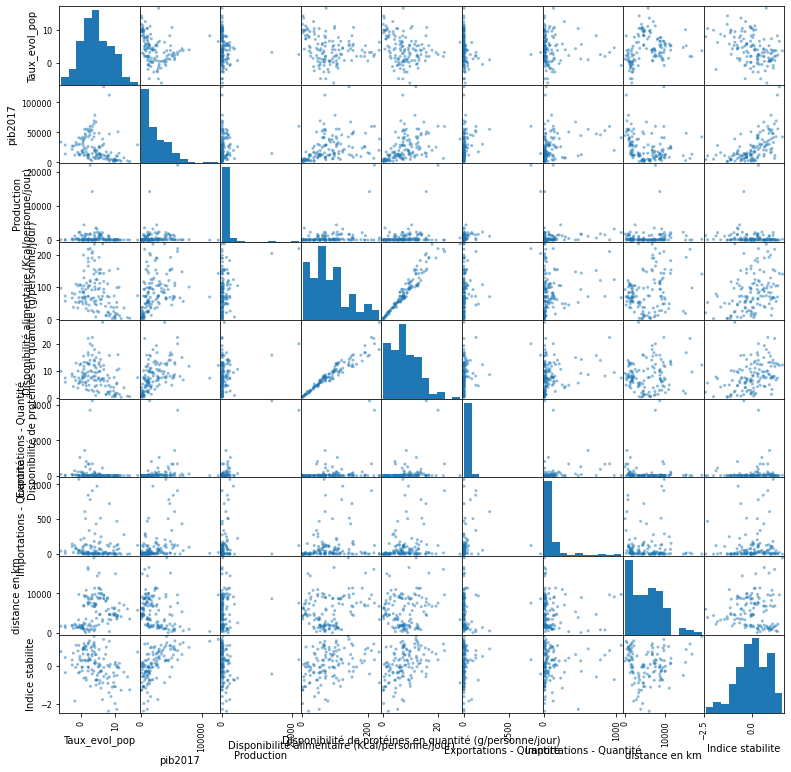

In [21]:
scatter_matrix(result,figsize=(13,13))
plt.show()

## Dendrogramme

Utilisé pour illustrer l'arrangement de groupes générés par un regroupement hiérarchique.
Le programme commence par calculer les distances entre chaque paire de classes dans le fichier . Ensuite, il fusionne successivement les paires de classes les plus proches. Après chaque fusion, les distances entre toutes les paires de classes sont mises à jour. Les distances auxquelles les signatures de classes sont fusionnées permettent de créer un dendrogramme.

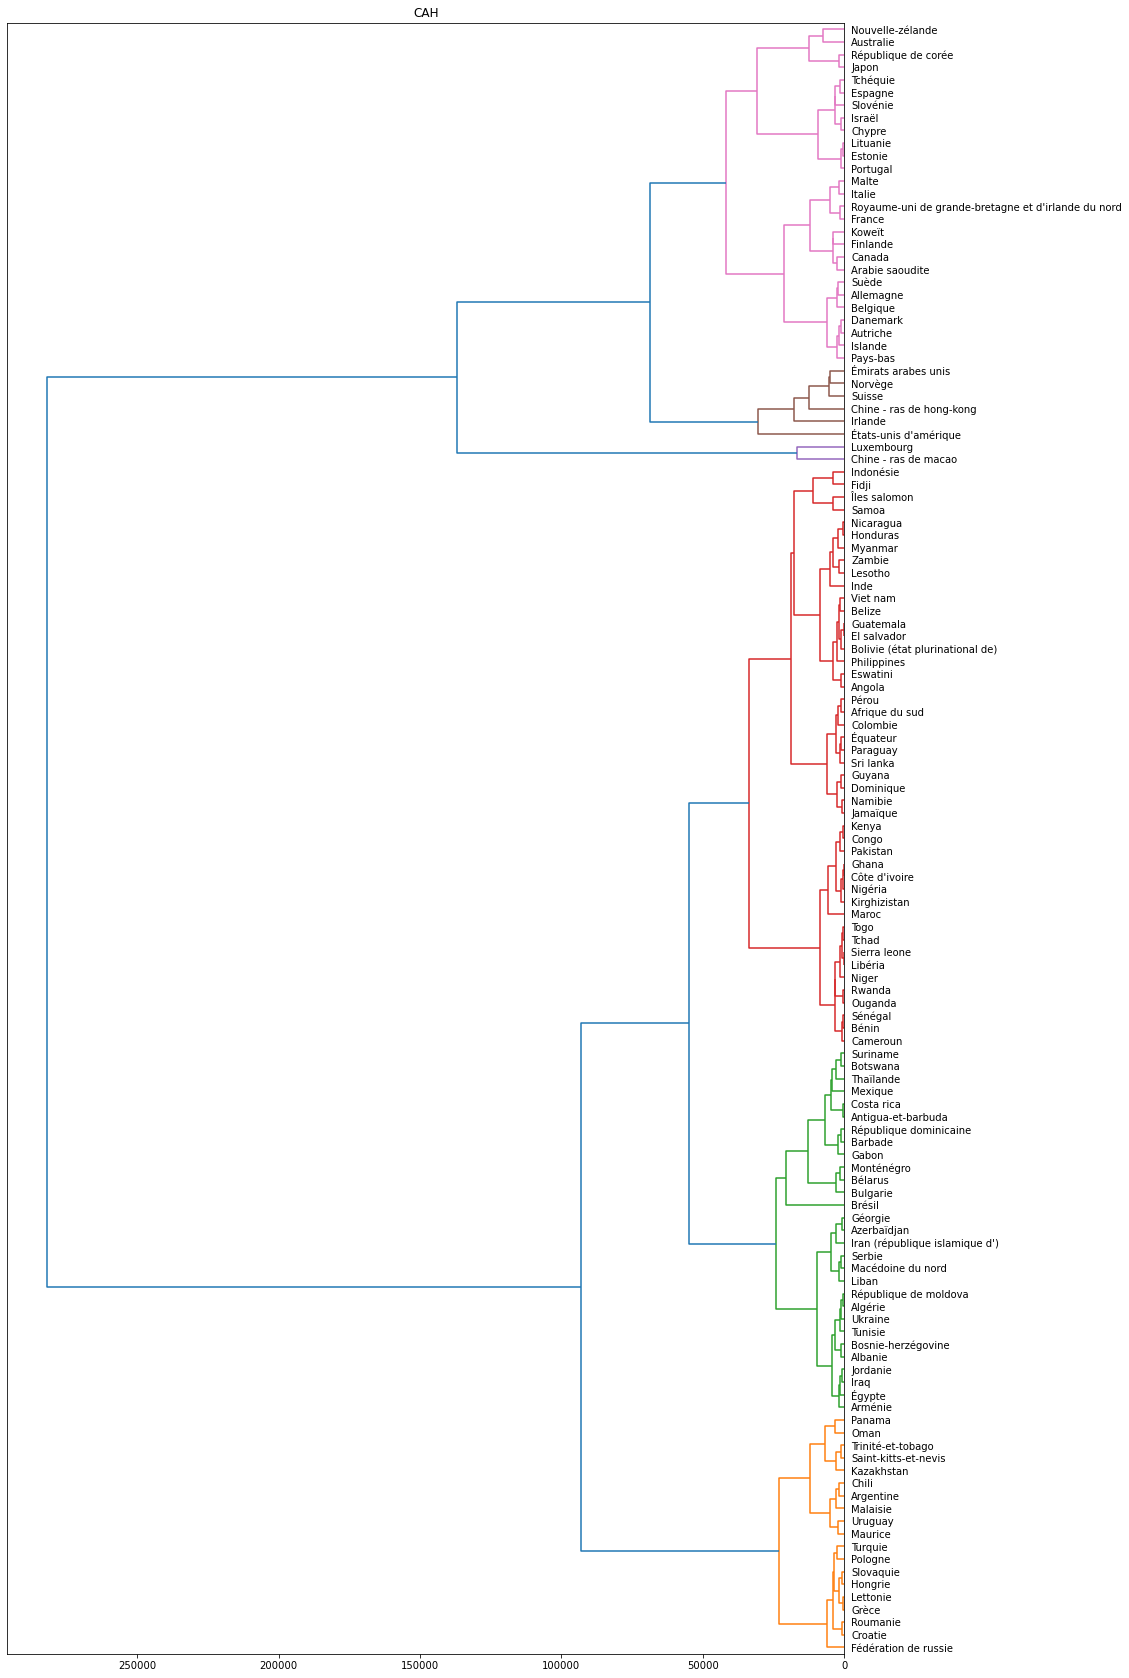

<Figure size 432x288 with 0 Axes>

In [22]:
result_complet = result_complet.set_index('Zone')
#générer la matrice des liens
Z = linkage(result,method='ward',metric='euclidean')
#affichage du dendrogramme
plt.figure(figsize=(15,30))
plt.title("CAH")
dendrogram(Z,labels=result_complet.index,orientation='left',color_threshold=50000,  leaf_font_size=10)
plt.show()
plt.savefig('dendrogram.png')

Je choisi de 'couper' le dendrogramme a 50000 pour la création de 6 groupes

## Découpe et création des groupes

In [23]:
#découpage à la hauteur t = 50000 ==> identifiants de 6 groupes obtenus
groupes_cah = fcluster(Z,t=50000,criterion='distance')

#index triés des groupes
idg = np.argsort(groupes_cah)

#affichage des observations et leurs groupes
(pandas.DataFrame(result_complet.index[idg],groupes_cah[idg]))

Zone
1                                          Kazakhstan
1                                               Chili
1                                             Croatie
1                                             Maurice
1                                   Trinité-et-tobago
..                                                ...
6                                            Lituanie
6                                              France
6   Royaume-uni de grande-bretagne et d'irlande du...
6                                            Finlande
6                                 République de corée

[129 rows x 1 columns]

## Affichage des pays dans les groupes correspondant

In [24]:
for i in range(1,7):
    print(f"Group {i}:")
    print(", ".join(result_complet.index[idg][groupes_cah[idg] == i].sort_values()))
    print(" ")

Group 1:
Argentine, Chili, Croatie, Fédération de russie, Grèce, Hongrie, Kazakhstan, Lettonie, Malaisie, Maurice, Oman, Panama, Pologne, Roumanie, Saint-kitts-et-nevis, Slovaquie, Trinité-et-tobago, Turquie, Uruguay
 
Group 2:
Albanie, Algérie, Antigua-et-barbuda, Arménie, Azerbaïdjan, Barbade, Bosnie-herzégovine, Botswana, Brésil, Bulgarie, Bélarus, Costa rica, Gabon, Géorgie, Iran (république islamique d'), Iraq, Jordanie, Liban, Macédoine du nord, Mexique, Monténégro, République de moldova, République dominicaine, Serbie, Suriname, Thaïlande, Tunisie, Ukraine, Égypte
 
Group 3:
Afrique du sud, Angola, Belize, Bolivie (état plurinational de), Bénin, Cameroun, Colombie, Congo, Côte d'ivoire, Dominique, El salvador, Eswatini, Fidji, Ghana, Guatemala, Guyana, Honduras, Inde, Indonésie, Jamaïque, Kenya, Kirghizistan, Lesotho, Libéria, Maroc, Myanmar, Namibie, Nicaragua, Niger, Nigéria, Ouganda, Pakistan, Paraguay, Philippines, Pérou, Rwanda, Samoa, Sierra leone, Sri lanka, Sénégal, Tcha

## Données standardisées

La standardisation des données a pour objectif d’assurer une compatibilité optimale des données, en vue de leur réutilisation. L’application d’une « commune mesure » permet d’améliorer la qualité des données. Cette signification très spécifique fait référence à la transformation de données en soustrayant à chaque valeur une valeur de référence (classiquement une moyenne d'échantillon) et en la divisant par l'écart-type. Cette importante transformation rendra toutes les valeurs (indifféremment de leurs distributions et unités de mesures originales) en unités compatibles avec distribution de moyenne 0 et d'écart-type 1. 

In [25]:
X = result.values
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

## PCA avec 8 composants

Les composants nous servent a voir la où l'on va couper

In [26]:
Mypca = decomposition.PCA(n_components=8)
Mypca.fit(X_scaled)

PCA(n_components=8)

Avec 8 composants, nous gardons 99% de nos données

In [27]:
print(Mypca.explained_variance_ratio_)
print(Mypca.explained_variance_ratio_.sum())

[0.34369104 0.19681665 0.15025008 0.1093945  0.08291857 0.07323732
 0.0290393  0.01180433]
0.997151793042639


## Représentation graphique pour plus de visibilité

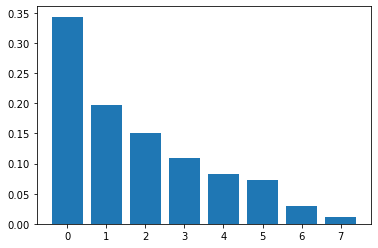

In [28]:
plt.bar(range(len(Mypca.explained_variance_ratio_)),Mypca.explained_variance_ratio_)
plt.show()

Avec 3 composants, nous gardons 68% de nos données ce qui nous permet de faire 3 graphiques avec ces composants.

## Ajustement de la PCA

In [29]:
pca = decomposition.PCA(n_components=3)
pca.fit(X_scaled)

PCA(n_components=3)

## Représentation graphique du 1er et 2ème composants

<Figure size 1080x720 with 0 Axes>

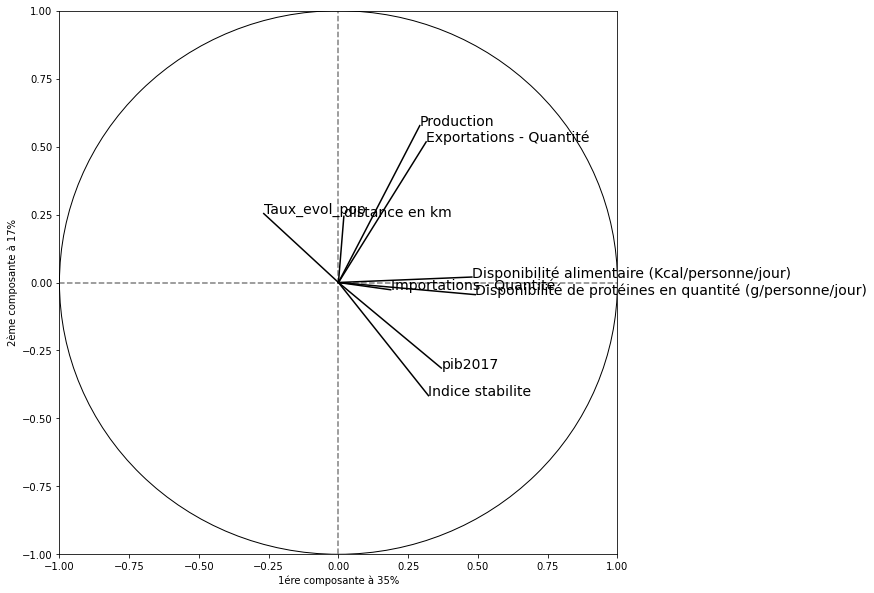

In [30]:
# projeter X sur les composantes principales
X_projected = pca.transform(X_scaled)

# afficher chaque observation
plt.figure(figsize=(15,10))

fig =  px.scatter(x=X_projected[:, 0], y=X_projected[:, 1],
    # colorer en utilisant la variable 'Continent'
    color=result_complet['Continent'])
fig.update_layout(width=800, height=800, title = 'représentation des 2 premiéres composantes',
                  xaxis=dict(title='1ere composante à 35%'),
                  yaxis=dict(title='2eme composante à 17%')
                           )

fig.show()

# Cercle des corrélations
pcs = pca.components_

fig,ax = plt.subplots(figsize=(10,10))

# Afficher une ligne horizontale y=0
plt.plot([-1, 1], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-1, 1], color='grey', ls='--')

# Afficher un cercle de diametre 1
cercle = plt.Circle((0, 0),1, color='black', fill=False)
ax.add_artist(cercle)

# Afficher le nom des axes x et y
plt.xlabel('1ére composante à 35%')
plt.ylabel('2ème composante à 17%')

plt.xlim([-1, 1])
plt.ylim([-1, 1])

# Variable de l'acp
for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):

    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (result.columns[i]) de la performance
    plt.text(x, y, result.columns[i], fontsize='14')


plt.show()


## Représentation graphique du 1er et 3ème composants

<Figure size 720x720 with 0 Axes>

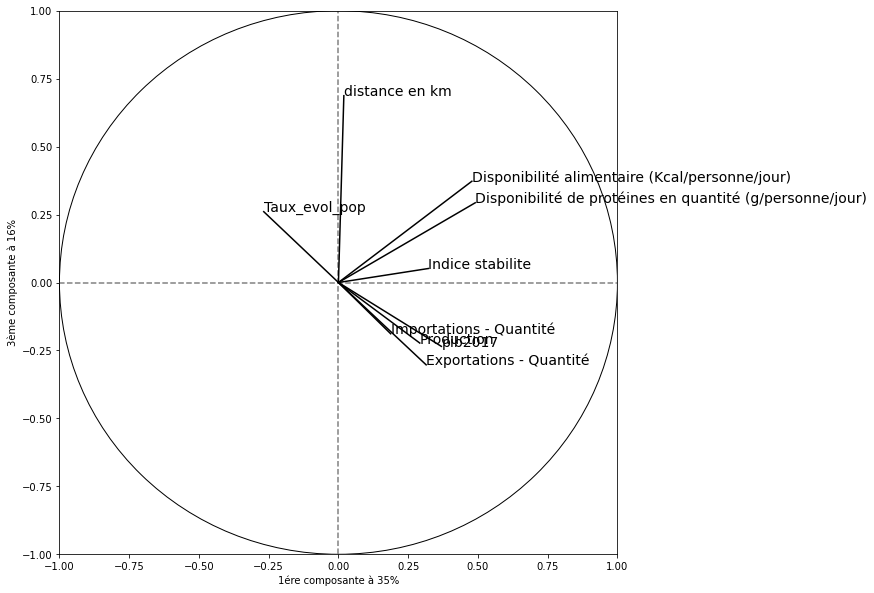

In [31]:
# projeter X sur les composantes principales
X_projected = pca.transform(X_scaled)



# afficher chaque observation
plt.figure(figsize=(10,10))
fig1 = px.scatter(x=X_projected[:, 0], y=X_projected[:, 2],
    # colorer en utilisant la variable 'Continent'
    color=result_complet['Continent'])
fig1.update_layout(width=800, height=800, title = 'représentation de la 1ére et 3éme composantes',
                   xaxis=dict(title='1ere composante à 35%'),
                   yaxis=dict(title='3eme composante à 16%')
                           )
fig1.show()

pcs = pca.components_

fig,ax = plt.subplots(figsize=(10,10))

# Afficher une ligne horizontale y=0
plt.plot([-1, 1], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-1, 1], color='grey', ls='--')

# Afficher un cercle de diametre 1
cercle = plt.Circle((0, 0),1, color='black', fill=False)
ax.add_artist(cercle)

# Afficher le nom des axes x et y
plt.xlabel('1ére composante à 35%')
plt.ylabel('3ème composante à 16%')

plt.xlim([-1, 1])
plt.ylim([-1, 1])

# Variable de l'acp
for i, (x, y) in enumerate(zip(pcs[0, :], pcs[2, :])):

    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (result.columns[i]) de la performance
    plt.text(x, y, result.columns[i], fontsize='14')


plt.show()

## Représentation graphique du 2ème et 3ème composants

<Figure size 1080x720 with 0 Axes>

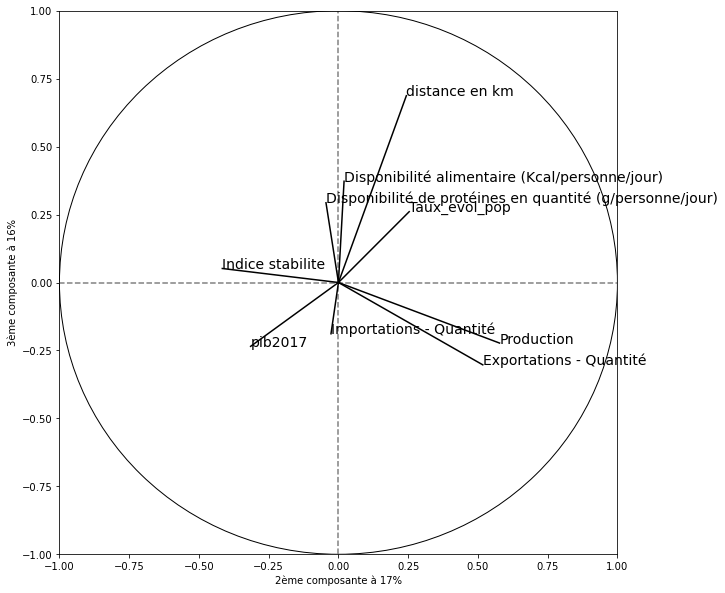

In [32]:
# projeter X sur les composantes principales
X_projected = pca.transform(X_scaled)


# afficher chaque observation
plt.figure(figsize=(15,10))
fig2 = px.scatter(x=X_projected[:, 1], y=X_projected[:, 2],
    # colorer en utilisant la variable 'Continent'
    color=result_complet['Continent'])
fig2.update_layout(width=800, height=800, title = 'représentation de la 2éme et 3éme composantes',
                   xaxis=dict(title='2ème composante à 17%'),
                   yaxis=dict(title='3ème composante à 16%')
                           )
fig2.show()


# cercle des corrélations
pcs = pca.components_

fig,ax = plt.subplots(figsize=(10,10))

# Afficher une ligne horizontale y=0
plt.plot([-1, 1], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-1, 1], color='grey', ls='--')

# Afficher un cercle de diametre 1
cercle = plt.Circle((0, 0),1, color='black', fill=False)
ax.add_artist(cercle)

# Afficher le nom des axes x et y
plt.xlabel('2ème composante à 17%')
plt.ylabel('3ème composante à 16%')

plt.xlim([-1, 1])
plt.ylim([-1, 1])

# Variable de l'acp
for i, (x, y) in enumerate(zip(pcs[1, :], pcs[2, :])):

    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (result.columns[i]) de la performance
    plt.text(x, y, result.columns[i], fontsize='14')


plt.show()

Suite a ces 3 graphiques, nous pouvons constater que les pays d'Europe ont le + fort pib par habitant et ont tendance a + importer, tandis que l'Amérique et l'Océanie penchent plus sur la disponibilité en protéine et sur une distance plus éloignée. L'Afrique et l'Asie auraient le Taux d'evolution de la population le + fort.

## Kmeans

Le clustering est une discipline particulière du Machine Learning ayant pour objectif de séparer vos données en groupes homogènes ayant des caractéristiques communes.

In [33]:
inertia = []
k_range = range(1,10)
for k in k_range:
    model = KMeans(n_clusters=k).fit(X_projected)
    inertia.append(model.inertia_)

## Représentation graphique pour visualiser le bon nombre de cluster

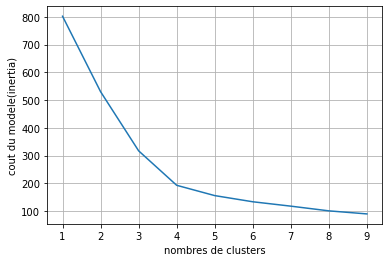

In [34]:
plt.plot(k_range, inertia)
plt.xlabel('nombres de clusters')
plt.ylabel('cout du modele(inertia)')
plt.grid(True)

Nous appliquons la technique du coude pour déterminé le nombre de clusters idéal. Ici, il y en aurait 4.

In [35]:
modele = KMeans(n_clusters=4).fit(X_projected)
modele

KMeans(n_clusters=4)

Je relance l'algorithme des K-means en indiquant le nombre de clusters choisi.

## Coordonnées des 4 centres des clusters

In [36]:
modele.cluster_centers_
centroide = pandas.DataFrame(modele.cluster_centers_, columns = ['centroideX', 'centroideY', 'centroideZ'])
centroide

centroideX  centroideY  centroideZ
0   -1.486573    0.561470    0.105447
1    0.737752   -1.014753   -1.088499
2    6.708817    7.896210   -2.200302
3    1.492880   -0.267847    1.442229

## Coordonnées de chaques pays

In [37]:
cluster1 = pandas.DataFrame(modele.labels_, columns = ['cluster'])
cluster2 = pandas.DataFrame(X_projected, columns=['pca1', 'pca2', 'pca3'])
cluster = pandas.concat([cluster1, cluster2], axis=1)
cluster

cluster      pca1      pca2      pca3
0          3  1.135274  0.677094  1.102353
1          1 -0.164666 -0.828150 -0.697667
2          0 -2.153573  0.464341 -0.785261
3          1  1.792977 -0.547559 -2.386562
4          0 -1.791234  0.704012  0.353349
..       ...       ...       ...       ...
124        0 -1.693415  0.991074 -0.453141
125        3  2.328592 -1.231311  0.129129
126        0 -0.794586  0.409599  1.072834
127        2  7.899142  7.974937 -2.633936
128        0 -2.062795  0.884714  1.691205

[129 rows x 4 columns]

## Représentation par un nuage de points en 3d

In [38]:
cluster.head()
scatter = dict(
    mode = "markers",
    name = "clusters",
    type = "scatter3d",
    x = cluster['pca1'], y = cluster['pca2'], z = cluster['pca3'],
    marker = dict( size=5, color=cluster.cluster )
)
clusters = dict(
    mode = 'markers',
    name = "centroides",
    type = "scatter3d",
    x = centroide['centroideX'], y = centroide['centroideY'], z = centroide['centroideZ'],
    marker = dict(size=15, color = 'rgb(228,26,28)', symbol='cross')
)
layout = dict(
    title = 'clusters avec centroides',
    scene = dict(
        xaxis = dict( zeroline=False ),
        yaxis = dict( zeroline=False ),
        zaxis = dict( zeroline=False ),  
    )
)
fig = dict( data=[scatter, clusters], layout=layout )
# Use py.iplot() for IPython notebook
pyoff.iplot(fig, filename='clusters avec centroides')


Les 4 clusters sont bien distinct avec leurs centres ce qui permets de valider la cohérences de nos données

## Visualisation de nos clusters avec les moyennes par groupe

In [39]:
result_complet = result_complet.reset_index()
dfg1 = cluster.merge(result_complet, how = 'left', left_index = True, right_index = True)
dfg = dfg1.groupby('cluster').mean()
dfg

pca1      pca2      pca3  Taux_evol_pop       pib2017  \
cluster                                                              
0       -1.486573  0.561470  0.105447       6.997586   9230.084483   
1        0.737752 -1.014753 -1.088499       0.476750  40055.890000   
2        6.708817  7.896210 -2.200302       2.890000  37317.150000   
3        1.492880 -0.267847  1.442229       4.158276  30767.337931   

           Production  Disponibilité alimentaire (Kcal/personne/jour)  \
cluster                                                                 
0          457.741379                                       44.482759   
1          575.800000                                       77.800000   
2        18057.500000                                      211.500000   
3          528.172414                                      159.103448   

         Disponibilité de protéines en quantité (g/personne/jour)  \
cluster                                                             
0                                                 4.247069          
1                                                 8.375500          
2                                                17.805000          
3                                                14.329310          

         Exportations - Quantité  Importations - Quantité  distance en km  \
cluster                                                                     
0                      28.206897                51.482759     6308.586207   
1                     156.350000               158.150000     1740.700000   
2                    3957.500000                63.000000     8061.000000   
3                      50.206897               149.275862     9004.000000   

         Indice stabilite  
cluster                    
0               -0.542069  
1                0.592500  
2               -0.040000  
3                0.433448

Nous pouvons constater que le groupe 0 est le groupe qui a le + fort PIB. La distance de celui ci est le + proche de la France ce qui nous fait penser a un 'groupe' Europe. Ce groupe serait en cohérence avec le résultat de l'acp

## Changement de nom de pays en anglais pour une représantation heat map

In [40]:
maps = pandas.merge(dfg1, gps, on='Zone', how='inner')

maps['Zone'] = maps['Zone'].replace(['Afrique du sud'], 'South Africa')
maps['Zone'] = maps['Zone'].replace(['Albanie'], 'Albania')
maps['Zone'] = maps['Zone'].replace(['Algérie'], 'Algeria')
maps['Zone'] = maps['Zone'].replace(['Allemagne'], 'Germany')
maps['Zone'] = maps['Zone'].replace(['Antigua-et-barbuda'], 'Antigua and Barbuda')
maps['Zone'] = maps['Zone'].replace(['Arabie saoudite'], 'Saudi Arabia')
maps['Zone'] = maps['Zone'].replace(['Argentine'], 'Argentina')
maps['Zone'] = maps['Zone'].replace(['Arménie'], 'Armenia')
maps['Zone'] = maps['Zone'].replace(['Australie'], 'Australia')
maps['Zone'] = maps['Zone'].replace(['Autriche'], 'Austria')
maps['Zone'] = maps['Zone'].replace(['Azerbaïdjan'], 'Azerbaijan')
maps['Zone'] = maps['Zone'].replace(['Barbade'], 'Barbados')
maps['Zone'] = maps['Zone'].replace(['Belgique'], 'Belgium')
maps['Zone'] = maps['Zone'].replace(['Bolivie (état plurinational de)'], 'Bolivia')
maps['Zone'] = maps['Zone'].replace(['Bosnie-herzégovine'], 'Bosnia and Herzegovina')
maps['Zone'] = maps['Zone'].replace(['Brésil'], 'Brazil')
maps['Zone'] = maps['Zone'].replace(['Bulgarie'], 'Bulgaria')
maps['Zone'] = maps['Zone'].replace(['Bélarus'], 'Belarus')
maps['Zone'] = maps['Zone'].replace(['Bénin'], 'Benin')
maps['Zone'] = maps['Zone'].replace(['Cameroun'], 'Cameroon')
maps['Zone'] = maps['Zone'].replace(['Chili'], 'Chile')
maps['Zone'] = maps['Zone'].replace(['Chine - ras de hong-kong'], 'Hong Kong')
maps['Zone'] = maps['Zone'].replace(['Chine - ras de macao'], 'Macao')
maps['Zone'] = maps['Zone'].replace(['Chypre'], 'Cyprus')
maps['Zone'] = maps['Zone'].replace(['Colombie'], 'Colombia')
maps['Zone'] = maps['Zone'].replace(['Congo'], 'Republic of the Congo')
maps['Zone'] = maps['Zone'].replace(['Costa rica'], 'Costa Rica')
maps['Zone'] = maps['Zone'].replace(['Croatie'], 'Croatia')
maps['Zone'] = maps['Zone'].replace(['Côte d\'ivoire'], 'Ivory Coast')
maps['Zone'] = maps['Zone'].replace(['Danemark'], 'Denmark')
maps['Zone'] = maps['Zone'].replace(['Dominique'], 'Dominica')
maps['Zone'] = maps['Zone'].replace(['El salvador'], 'El Salvador')
maps['Zone'] = maps['Zone'].replace(['Espagne'], 'Spain')
maps['Zone'] = maps['Zone'].replace(['Estonie'], 'Estonia')
maps['Zone'] = maps['Zone'].replace(['Eswatini'], 'Swaziland')
maps['Zone'] = maps['Zone'].replace(['Fidji'], 'Fiji')
maps['Zone'] = maps['Zone'].replace(['Finlande'], 'Finland')
maps['Zone'] = maps['Zone'].replace(['Fédération de russie'], 'Russia')
maps['Zone'] = maps['Zone'].replace(['Grèce'], 'Greece')
maps['Zone'] = maps['Zone'].replace(['Géorgie'], 'Georgia')
maps['Zone'] = maps['Zone'].replace(['Hongrie'], 'Hungary')
maps['Zone'] = maps['Zone'].replace(['Inde'], 'India')
maps['Zone'] = maps['Zone'].replace(['Indonésie'], 'Indonesia')
maps['Zone'] = maps['Zone'].replace(['Iran (république islamique d\')'], 'Iran')
maps['Zone'] = maps['Zone'].replace(['Irlande'], 'Ireland')
maps['Zone'] = maps['Zone'].replace(['Islande'], 'Iceland')
maps['Zone'] = maps['Zone'].replace(['Israël'], 'Israel')
maps['Zone'] = maps['Zone'].replace(['Italie'], 'Italy')
maps['Zone'] = maps['Zone'].replace(['Jamaïque'], 'Jamaica')
maps['Zone'] = maps['Zone'].replace(['Japon'], 'Japan')
maps['Zone'] = maps['Zone'].replace(['Jordanie'], 'Jordan')
maps['Zone'] = maps['Zone'].replace(['Kirghizistan'], 'Kyrgyzstan')
maps['Zone'] = maps['Zone'].replace(['Koweït'], 'Kuwait')
maps['Zone'] = maps['Zone'].replace(['Lettonie'], 'Latvia')
maps['Zone'] = maps['Zone'].replace(['Liban'], 'Lebanon')
maps['Zone'] = maps['Zone'].replace(['Libéria'], 'Liberia')
maps['Zone'] = maps['Zone'].replace(['Lituanie'], 'Lithuania')
maps['Zone'] = maps['Zone'].replace(['Macédoine du nord'], 'Macedonia')
maps['Zone'] = maps['Zone'].replace(['Malaisie'], 'Malaysia')
maps['Zone'] = maps['Zone'].replace(['Malte'], 'Malta')
maps['Zone'] = maps['Zone'].replace(['Maroc'], 'Morocco')
maps['Zone'] = maps['Zone'].replace(['Maurice'], 'Mauritius')
maps['Zone'] = maps['Zone'].replace(['Mexique'], 'Mexico')
maps['Zone'] = maps['Zone'].replace(['Monténégro'], 'Montenegro')
maps['Zone'] = maps['Zone'].replace(['Namibie'], 'Namibia')
maps['Zone'] = maps['Zone'].replace(['Nigéria'], 'Nigeria')
maps['Zone'] = maps['Zone'].replace(['Norvège'], 'Norway')
maps['Zone'] = maps['Zone'].replace(['Nouvelle-zélande'], 'New Zealand')
maps['Zone'] = maps['Zone'].replace(['Ouganda'], 'Uganda')
maps['Zone'] = maps['Zone'].replace(['Pays-bas'], 'Netherlands')
maps['Zone'] = maps['Zone'].replace(['Pologne'], 'Poland')
maps['Zone'] = maps['Zone'].replace(['Pérou'], 'Peru')
maps['Zone'] = maps['Zone'].replace(['Roumanie'], 'Romania')
maps['Zone'] = maps['Zone'].replace(['Royaume-uni de grande-bretagne et d\'irlande du nord'], 'United Kingdom')
maps['Zone'] = maps['Zone'].replace(['République de corée'], 'South Korea')
maps['Zone'] = maps['Zone'].replace(['République de moldova'], 'Moldova')
maps['Zone'] = maps['Zone'].replace(['République dominicaine'], 'Dominican Republic')
maps['Zone'] = maps['Zone'].replace(['Saint-kitts-et-nevis'], 'Saint Kitts and Nevis')
maps['Zone'] = maps['Zone'].replace(['Serbie'], 'Serbia')
maps['Zone'] = maps['Zone'].replace(['Sierra leone'], 'Sierra Leone')
maps['Zone'] = maps['Zone'].replace(['Slovaquie'], 'Slovakia')
maps['Zone'] = maps['Zone'].replace(['Slovénie'], 'Slovenia')
maps['Zone'] = maps['Zone'].replace(['Sri lanka'], 'Sri Lanka')
maps['Zone'] = maps['Zone'].replace(['Suisse'], 'Switzerland')
maps['Zone'] = maps['Zone'].replace(['Suède'], 'Sweden')
maps['Zone'] = maps['Zone'].replace(['Sénégal'], 'Senegal')
maps['Zone'] = maps['Zone'].replace(['Tchad'], 'Chad')
maps['Zone'] = maps['Zone'].replace(['Tchéquie'], 'Czech Republic')
maps['Zone'] = maps['Zone'].replace(['Thaïlande'], 'Thailand')
maps['Zone'] = maps['Zone'].replace(['Trinité-et-tobago'], 'Trinidad and Tobago')
maps['Zone'] = maps['Zone'].replace(['Tunisie'], 'Tunisia')
maps['Zone'] = maps['Zone'].replace(['Turquie'], 'Turkey')
maps['Zone'] = maps['Zone'].replace(['Viet nam'], 'Vietnam')
maps['Zone'] = maps['Zone'].replace(['Zambie'], 'Zambia')
maps['Zone'] = maps['Zone'].replace(['Égypte'], 'Egypt')
maps['Zone'] = maps['Zone'].replace(['Émirats arabes unis'], 'United Arab Emirates')
maps['Zone'] = maps['Zone'].replace(['Équateur'], 'Ecuador')
maps['Zone'] = maps['Zone'].replace(['États-unis d\'amérique'], 'United States of America')
maps['Zone'] = maps['Zone'].replace(['Îles salomon'], 'Solomon Islands')


## Représentation des clusters sur une map monde

In [41]:
mymap = folium.Map(tiles = 'Stamen Terrain',min_zoom = 1.5)
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
country_shapes = f'{url}/world-countries.json'
folium.Choropleth(
    geo_data = country_shapes,
    min_zoom=1.5,
    name='clusters',
    data=maps,
    columns=['Zone', 'cluster'],
    key_on='feature.properties.name',
    fill_color='OrRd',
    nan_fill_color='black',
    legend_name = 'clusters',
).add_to(mymap)

def plotDot(maps):
    folium.CircleMarker(location = (maps.lat, maps.long),
                       radius = 5,
                       weight = 2,
                       popup = [maps.Zone, maps.cluster],
                       fill_color = '#000000').add_to(mymap)
maps.apply(plotDot, axis = 1)
mymap.fit_bounds(mymap.get_bounds())
mymap

display(mymap)

 Nous pouvons distinguer nos 4 groupes. Les pays en noir sont ceux où je n'ai pas assez de données pour l'analyse.

## Création d'un heatmap pour regarder la corrélation des clusters

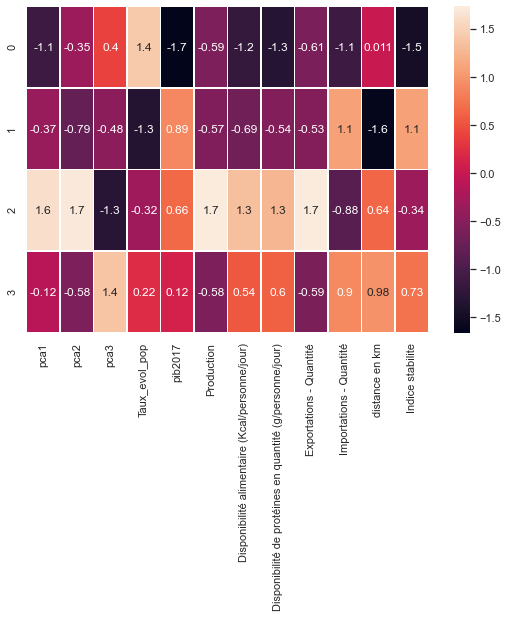

In [42]:
sns.set_theme()

dfgs = preprocessing.StandardScaler().fit_transform(dfg)
dfgs = pandas.DataFrame(dfgs, columns=dfg.columns)
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(dfgs, annot=True, linewidths=.5, ax=ax)
plt.show()

Confirmztion du groupe 0 étant le pib le + fort avec trés peu de production. Etant donnée que ce groupe serait celui de l'Europe, il serait possible d'investir ici du au pouvoir d'achat par habitant, de l'indice de stabilité bon et d'un point de vue écologique, la distance rapprochée des pays.

In [43]:
display(dfg1[['cluster', 'pib2017']].groupby('cluster').mean())
display(dfg1[['cluster', 'pib2017']].groupby('cluster').count())


pib2017
cluster              
0         9230.084483
1        40055.890000
2        37317.150000
3        30767.337931

pib2017
cluster         
0             58
1             40
2              2
3             29

Il y a 40 pays dans le groupe 0, ce qui nous laisse un bon choix de pays

## Top des pays a investir avec un pib et un taux d'évolution de population confortable

In [44]:
(dfg1
         # Juste le cluster 3
         .query('cluster == 3')
         
         # Top PIB
         .sort_values(by='pib2017', ascending=False)
 
         # Top 10
         .head(10)
 
         # Top Evolution population
         .sort_values(by='Taux_evol_pop', ascending=False)
)

cluster      pca1      pca2      pca3                      Zone  \
65         3  1.226507 -0.378510  0.948659                    Koweït   
6          3  1.656680 -0.129504  0.198866           Arabie saoudite   
89         3  0.390414 -0.207498  1.215922                    Panama   
26         3  2.782863 -2.130887  0.658005      Chine - ras de macao   
57         3  2.714767 -0.035723  1.831962                    Israël   
9          3  2.394997 -0.131187  2.814575                 Australie   
125        3  2.328592 -1.231311  0.129129       Émirats arabes unis   
23         3  2.183967 -0.701624  0.612900                    Canada   
85         3  1.648743 -0.497528  3.022782          Nouvelle-zélande   
25         3  4.387696 -0.575594  0.976852  Chine - ras de hong-kong   

     Taux_evol_pop   pib2017  Production  \
65           10.79   50855.6        56.0   
6             8.27   47306.2       616.0   
89            6.60   30446.8       198.0   
26            6.56  126184.0         3.0   
57            6.29   38834.0       629.0   
9             5.23   48482.6      1269.0   
125           4.33   67183.6        48.0   
23            3.80   48317.1      1417.0   
85            3.70   42285.3       223.0   
25            3.22   59849.2        24.0   

     Disponibilité alimentaire (Kcal/personne/jour)  \
65                                            156.0   
6                                             151.0   
89                                            117.0   
26                                            142.0   
57                                            234.0   
9                                             192.0   
125                                           147.0   
23                                            154.0   
85                                            140.0   
25                                            210.0   

     Disponibilité de protéines en quantité (g/personne/jour)  \
65                                               15.87          
6                                                15.57          
89                                               10.34          
26                                               11.90          
57                                               27.87          
9                                                16.60          
125                                              14.80          
23                                               13.86          
85                                               12.02          
25                                               22.26          

     Exportations - Quantité  Importations - Quantité Continent  \
65                       4.0                    137.0      Asie   
6                       10.0                    722.0      Asie   
89                       0.0                     20.0  Amérique   
26                       0.0                     23.0      Asie   
57                       3.0                      0.0      Asie   
9                       42.0                     16.0   Océanie   
125                     94.0                    433.0      Asie   
23                     163.0                    182.0  Amérique   
85                      23.0                      1.0   Océanie   
25                     663.0                    907.0      Asie   

     distance en km  Indice stabilite  
65             4379             -0.05  
6              4635             -0.58  
89             8697              0.39  
26             9602              1.43  
57             3322             -0.89  
9             15149              0.89  
125            5306              0.62  
23             6604              1.10  
85            19013              1.59  
25             9616              0.83

Le Luxembourg, l'Irlande et la Suisse font partie du top 3